In [35]:
# import the necessary libraries
import matplotlib.pyplot as plt
import warnings
from rfpimp import *
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')
# added new libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

## The whole data. Hotel clusters 0-99.

In [2]:
data = pd.read_csv('data/train.csv'); data.shape

(37670293, 24)

## The subset of data. Hotel clusters 0-9.

In [5]:
df = data.loc[data['hotel_cluster'].isin(list(range(10)))]; df.shape

(3920622, 24)

## 1 Million Samples

## Load Data

In [6]:
#reading in the file into pandas dataframe
# df = pd.read_csv('train_reduce.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3920622 entries, 0 to 37670289
Data columns (total 24 columns):
date_time                    object
site_name                    int64
posa_continent               int64
user_location_country        int64
user_location_region         int64
user_location_city           int64
orig_destination_distance    float64
user_id                      int64
is_mobile                    int64
is_package                   int64
channel                      int64
srch_ci                      object
srch_co                      object
srch_adults_cnt              int64
srch_children_cnt            int64
srch_rm_cnt                  int64
srch_destination_id          int64
srch_destination_type_id     int64
is_booking                   int64
cnt                          int64
hotel_continent              int64
hotel_country                int64
hotel_market                 int64
hotel_cluster                int64
dtypes: float64(1), int64(20), object(3)


In [8]:
# separating the target variable and the predictor variables
df_X = df.drop(columns=['hotel_cluster'])
df_y = df['hotel_cluster']

In [9]:
# Checking the distributions of each target label
clusters = []
for idx in range(0, 10):
    clusters.append(df_y.loc[(df_y == idx)].shape[0])
    print(f"{idx}: Percentages: {(df_y.loc[(df_y == idx)].shape[0]) / df_y.shape[0]}\
    Count: {df_y.loc[(df_y == idx)].shape[0]}")

0: Percentages: 0.09689610475072578    Count: 379893
1: Percentages: 0.11546484205822444    Count: 452694
2: Percentages: 0.1108290980359749    Count: 434519
3: Percentages: 0.05745261848757672    Count: 225250
4: Percentages: 0.08974315810093399    Count: 351849
5: Percentages: 0.15818765491802067    Count: 620194
6: Percentages: 0.09804337168949212    Count: 384391
7: Percentages: 0.06438952798816107    Count: 252447
8: Percentages: 0.08443991795179438    Count: 331057
9: Percentages: 0.12455370601909595    Count: 488328


## bar graph for the number of samples per class

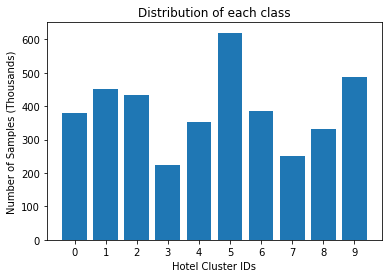

In [11]:
# bar graph for the number of samples per class
plt.bar([idx for idx in range(10)], [cluster/1000 for cluster in clusters])
plt.xticks(np.arange(10))
plt.title('Distribution of each class')
plt.xlabel('Hotel Cluster IDs')
plt.ylabel('Number of Samples (Thousands)')
#plt.savefig('Class Density.png')
plt.show()

In [12]:
# using stratified shuffle split to get 25% of the filter data while keeping the distribution (~ 1mil samples)
sss = StratifiedShuffleSplit(n_splits=1, train_size=0.25, random_state=0)
for train_idx, test_idx in sss.split(df_X, df_y):
    X_train, X_test = df_X.iloc[train_idx], df_X.iloc[test_idx]
    y_train, y_test = df_y.iloc[train_idx], df_y.iloc[test_idx]

In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 980155 entries, 6196179 to 25798231
Data columns (total 23 columns):
date_time                    980155 non-null object
site_name                    980155 non-null int64
posa_continent               980155 non-null int64
user_location_country        980155 non-null int64
user_location_region         980155 non-null int64
user_location_city           980155 non-null int64
orig_destination_distance    633029 non-null float64
user_id                      980155 non-null int64
is_mobile                    980155 non-null int64
is_package                   980155 non-null int64
channel                      980155 non-null int64
srch_ci                      978936 non-null object
srch_co                      978936 non-null object
srch_adults_cnt              980155 non-null int64
srch_children_cnt            980155 non-null int64
srch_rm_cnt                  980155 non-null int64
srch_destination_id          980155 non-null int64
srch_dest

In [14]:
#check the shape of training and testing data
print(f"X_train {X_train.shape}, y_train {y_train.shape}\n X_test {X_test.shape}, y_test {y_test.shape}")

X_train (980155, 23), y_train (980155,)
 X_test (2940467, 23), y_test (2940467,)


## Date Time Feature Engineering

In [15]:
#reset the index
sample_x = X_train.reset_index(drop=True)
sample_y = y_train.reset_index(drop=True)
sample_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980155 entries, 0 to 980154
Data columns (total 23 columns):
date_time                    980155 non-null object
site_name                    980155 non-null int64
posa_continent               980155 non-null int64
user_location_country        980155 non-null int64
user_location_region         980155 non-null int64
user_location_city           980155 non-null int64
orig_destination_distance    633029 non-null float64
user_id                      980155 non-null int64
is_mobile                    980155 non-null int64
is_package                   980155 non-null int64
channel                      980155 non-null int64
srch_ci                      978936 non-null object
srch_co                      978936 non-null object
srch_adults_cnt              980155 non-null int64
srch_children_cnt            980155 non-null int64
srch_rm_cnt                  980155 non-null int64
srch_destination_id          980155 non-null int64
srch_destination_

In [16]:
# feature engineering into datetime
sample_x['date_time'] = pd.to_datetime(sample_x['date_time'], yearfirst=True)
sample_x['srch_ci'] = pd.to_datetime(sample_x['srch_ci'], yearfirst=True, errors='coerce')
sample_x['srch_co'] = pd.to_datetime(sample_x['srch_co'], yearfirst=True, errors='coerce')

# timedelta for days in advance feature
sample_x['advance'] = sample_x['srch_ci'] - sample_x['date_time']
sample_x['advance'] = sample_x.advance.dt.days

# duration of stays
sample_x['duration'] = sample_x['srch_co'] - sample_x['srch_ci']
sample_x['duration'] = sample_x.duration.dt.days

In [17]:
sample_x.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,advance,duration
0,2013-10-17 08:57:23,24,2,3,50,5703,NaN,448165,0,0,1,2013-10-31,2013-11-03,2,0,1,669,3,0,1,2,50,212,13.0,3.0
1,2014-01-17 16:35:29,28,1,68,478,39206,NaN,219933,0,0,9,2014-10-22,2014-10-23,4,1,2,23195,6,0,1,6,170,313,277.0,1.0
2,2014-06-01 16:22:44,2,3,66,174,21496,1306.3787,324303,0,0,9,2014-12-30,2015-01-06,2,0,1,12219,6,0,1,4,8,118,211.0,7.0
3,2014-06-29 13:52:54,2,3,66,246,50661,156.7901,162512,0,0,9,2014-07-20,2014-07-23,2,0,1,8856,1,0,1,2,50,636,20.0,3.0
4,2014-12-15 16:12:11,2,3,66,311,577,NaN,135907,1,1,0,2015-04-18,2015-04-22,2,2,1,12257,6,0,1,4,51,1509,123.0,4.0


In [18]:
new_x = sample_x.drop(columns=['user_id', 'site_name',
                               'user_location_region',
                               'date_time', 'srch_ci',
                               'srch_co'])

In [19]:
new_x.head()

,posa_continent,user_location_country,user_location_city,orig_destination_distance,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,advance,duration
0,2,3,5703,NaN,0,0,1,2,0,1,669,3,0,1,2,50,212,13.0,3.0
1,1,68,39206,NaN,0,0,9,4,1,2,23195,6,0,1,6,170,313,277.0,1.0
2,3,66,21496,1306.3787,0,0,9,2,0,1,12219,6,0,1,4,8,118,211.0,7.0
3,3,66,50661,156.7901,0,0,9,2,0,1,8856,1,0,1,2,50,636,20.0,3.0
4,3,66,577,NaN,1,1,0,2,2,1,12257,6,0,1,4,51,1509,123.0,4.0


In [20]:
new_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980155 entries, 0 to 980154
Data columns (total 19 columns):
posa_continent               980155 non-null int64
user_location_country        980155 non-null int64
user_location_city           980155 non-null int64
orig_destination_distance    633029 non-null float64
is_mobile                    980155 non-null int64
is_package                   980155 non-null int64
channel                      980155 non-null int64
srch_adults_cnt              980155 non-null int64
srch_children_cnt            980155 non-null int64
srch_rm_cnt                  980155 non-null int64
srch_destination_id          980155 non-null int64
srch_destination_type_id     980155 non-null int64
is_booking                   980155 non-null int64
cnt                          980155 non-null int64
hotel_continent              980155 non-null int64
hotel_country                980155 non-null int64
hotel_market                 980155 non-null int64
advance             

In [21]:
# Train test split the 5% data
xtrain, xtest, ytrain, ytest = train_test_split(new_x, sample_y, test_size=.2 ,random_state=42)
xtrain.shape, xtest.shape

((784124, 19), (196031, 19))

In [22]:
# Building the pipeline
def make_pipeline():
    """This function here makes the pipeline but does not include the clf to prevent data leakage."""
    
    date_features = ['advance', 'duration']
    date_transformer = Pipeline(steps=[('imp', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0))])

    distance = ['orig_destination_distance']
    distance_transformer = Pipeline(steps=[('imp', SimpleImputer(missing_values=np.nan, strategy='mean'))])

    preprocessor = ColumnTransformer(transformers=[('date', date_transformer, date_features),
                                                   ('dist', distance_transformer, distance)],
                                    remainder='passthrough')

    pipeline = Pipeline([('preprocess', preprocessor)])
    
    return pipeline

## Random Forest with random search

In [25]:
def make_random_cv(cv, n_iter, n_estimators):
    """
    Steps:
    1. Define Estimator
    2. Define hyperparameter search space
    3. Instantiate RandomizedSearchCV
    """
    
    rf = RandomForestClassifier(n_estimators=n_estimators,
                                random_state=42, 
                                max_depth=10, 
                                oob_score=True,
                                n_jobs=4)
    
    params_grid = {'max_features': [2, 5, 10, 16],
                  'min_samples_leaf': [100, 500, 1000, 2000]}
    
    clf_random_cv = RandomizedSearchCV(estimator=rf, scoring='f1_weighted',
                                       param_distributions=params_grid,
                                       n_iter=n_iter, cv=cv)
                                         
    return clf_random_cv

In [26]:
# make the pipeline and transform the data
pipeline = make_pipeline()
trans_xtrain = pipeline.fit_transform(xtrain)
trans_xtest = pipeline.fit_transform(xtest)
trans_xtrain.shape # sanity check of datashape

(784124, 19)

## Random Forest with random serach for the training dataset

In [30]:
# creating the RandomizedSearchCV and using the best estimator
randomize_clf = make_random_cv(3, 5, 1) # 3-fold, 5 iterations
randomize_clf.fit(trans_xtrain, ytrain)
best_rf = randomize_clf.best_estimator_ # returning the best estimator
randomize_clf.best_params_

{'min_samples_leaf': 100, 'max_features': 10}

In [32]:
# fitting the best estimator and getting the training scores
best_rf.fit(trans_xtrain, ytrain)
print(f"Out-of-Bag Accuracy: {best_rf.oob_score_}")
print(f"Training weighted-f1-Score: {f1_score(ytrain, best_rf.predict(trans_xtrain), average='weighted')}")

Out-of-Bag Accuracy: 0.24872086557738318
Training weighted-f1-Score: 0.4978698515754112


## Random Forest with random serach for the testing dataset

In [33]:
# transforming the test data and evaluating the model

# does this fit the testing data and then transform? 
trans_xtest = pipeline.fit_transform(xtest) # #What if I want to impute based on the training data to prevent data leakage
print(f"Test Accuracy: {accuracy_score(ytest, best_rf.predict(trans_xtest))}")
print(f"Training weighted-f1-Score: {f1_score(ytrain, best_rf.predict(trans_xtrain), average='weighted')}")

Test Accuracy: 0.5109497987563192
Training weighted-f1-Score: 0.4978698515754112


In [34]:
# creating the RandomizedSearchCV and using the best estimator
best_params = []
oob_scores = []
f1_train = []
f1_test = []
train_acc = []
test_acc = []

for n in tqdm([1, 5, 10, 20, 50, 100]):
    randomize_clf = make_random_cv(cv=3, n_iter=5, n_estimators=n)  # 3-fold, 5 iterations
    randomize_clf.fit(trans_xtrain, ytrain)
    best_rf = randomize_clf.best_estimator_  # returning the best estimator
    
    # fitting the best estimator and getting the training scores
    best_rf.fit(trans_xtrain, ytrain)
    train_acc.append(accuracy_score(ytrain, best_rf.predict(trans_xtrain)))  # train_acc
    test_acc.append(accuracy_score(ytest, best_rf.predict(trans_xtest)))  # test_acc
    oob_scores.append(best_rf.oob_score_)  # list of oob scores
    best_params.append(randomize_clf.best_params_)  # creating a list of best params
    f1_train.append(f1_score(ytrain, best_rf.predict(trans_xtrain), average='weighted'))  # train_f1
    f1_test.append(f1_score(ytest, best_rf.predict(trans_xtest), average='weighted'))  # test_f1

 50%|█████     | 3/6 [07:12<06:41, 133.68s/it]

KeyboardInterrupt: 

## Accuracy Plots vs. number of trees

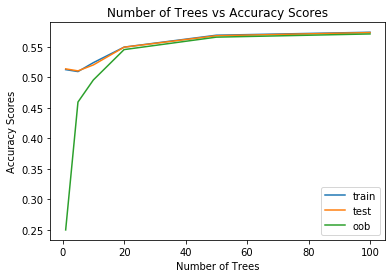

In [54]:
# Accuracy Plots
n_trees = [1, 5, 10, 20, 50, 100]
plt.plot(n_trees, train_acc, label='train')
plt.plot(n_trees, test_acc, label='test')
plt.plot(n_trees, oob_scores, label='oob')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy Scores')
plt.title('Number of Trees vs Accuracy Scores')
plt.legend(loc='lower right')
plt.savefig('AccuracyScores.png')
plt.show()

## F1-scores vs number of trees

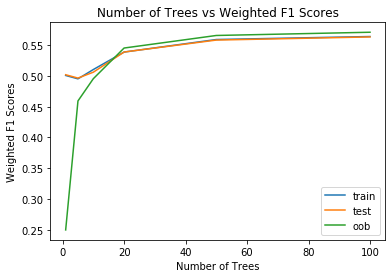

In [55]:
# F1-scores plots
plt.plot(n_trees, f1_train, label='train')
plt.plot(n_trees, f1_test, label='test')
plt.plot(n_trees, oob_scores, label='oob')
plt.xlabel('Number of Trees')
plt.ylabel('Weighted F1 Scores')
plt.title('Number of Trees vs Weighted F1 Scores')
plt.legend(loc='lower right')
plt.savefig('F1Scores.png')
plt.show()

In [39]:
best_params

[{'min_samples_leaf': 1000, 'max_features': 16},
 {'min_samples_leaf': 2000, 'max_features': 16},
 {'min_samples_leaf': 100, 'max_features': 5},
 {'min_samples_leaf': 500, 'max_features': 16},
 {'min_samples_leaf': 100, 'max_features': 16},
 {'min_samples_leaf': 100, 'max_features': 16}]

In [41]:
# Training the best model according to the plots
rf = RandomForestClassifier(random_state=42,
                            n_jobs=4,
                            n_estimators=50,
                            min_samples_leaf=100,
                            max_depth=15,
                            oob_score=True)
rf.fit(trans_xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
                       oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

## Random Forest with the "best" parameters for training and testing

## Accuracy

In [42]:
# Accuracy scores
print(f"Training Accuracy Score: {accuracy_score(ytrain, rf.predict(trans_xtrain))}")
print(f"Testing Accuracy Score: {accuracy_score(ytest, rf.predict(trans_xtest))}")
print(f"OOB Accuracy Score: {rf.oob_score_}")

Training Accuracy Score: 0.5670289393004168
Testing Accuracy Score: 0.556549729379537
OOB Accuracy Score: 0.5562117726277986


## F1- scores

In [46]:
# F1-scores
print(f"Training weighted-f1-Score: {f1_score(ytrain, best_rf.predict(trans_xtrain), average='weighted')}")
print(f"Testing weighted-f1-Score: {f1_score(ytest, best_rf.predict(trans_xtest), average='weighted')}")

Training weighted-f1-Score: 0.564168151217385
Testing weighted-f1-Score: 0.5634766919647923


## Summary for training data

In [44]:
# Training Classification Report
print(classification_report(ytrain, rf.predict(trans_xtrain)))

              precision    recall  f1-score   support

           0       0.61      0.87      0.72     75918
           1       0.99      1.00      0.99     90583
           2       0.52      0.43      0.47     86805
           3       0.63      0.29      0.40     45062
           4       0.45      0.62      0.52     70263
           5       0.45      0.48      0.46    124021
           6       0.44      0.26      0.33     76828
           7       0.46      0.43      0.45     50547
           8       0.65      0.70      0.67     66269
           9       0.48      0.48      0.48     97828

    accuracy                           0.57    784124
   macro avg       0.57      0.56      0.55    784124
weighted avg       0.57      0.57      0.56    784124



## Summary for testing

In [45]:
# Testing Classification Report
print(classification_report(ytest, rf.predict(trans_xtest)))

              precision    recall  f1-score   support

           0       0.60      0.87      0.71     19055
           1       0.99      1.00      0.99     22590
           2       0.51      0.40      0.45     21825
           3       0.61      0.27      0.38     11251
           4       0.45      0.60      0.52     17699
           5       0.42      0.48      0.45     31027
           6       0.42      0.24      0.30     19270
           7       0.45      0.43      0.44     12565
           8       0.64      0.70      0.67     16495
           9       0.47      0.46      0.47     24254

    accuracy                           0.56    196031
   macro avg       0.56      0.54      0.54    196031
weighted avg       0.55      0.56      0.54    196031



In [49]:
new_x.columns

Index(['posa_continent', 'user_location_country', 'user_location_city',
       'orig_destination_distance', 'is_mobile', 'is_package', 'channel',
       'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt',
       'srch_destination_id', 'srch_destination_type_id', 'is_booking', 'cnt',
       'hotel_continent', 'hotel_country', 'hotel_market', 'advance',
       'duration'],
      dtype='object')

## Feature importance for Random Forest

In [52]:
# Feature importance
features = ['posa_continent', 'user_location_country', 'user_location_city',
       'orig_destination_distance', 'is_mobile', 'is_package', 'channel',
       'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt',
       'srch_destination_id', 'srch_destination_type_id', 'is_booking', 'cnt',
       'hotel_continent', 'hotel_country', 'hotel_market', 'advance',
       'duration']
df_imp = pd.DataFrame(trans_xtest, columns=features)

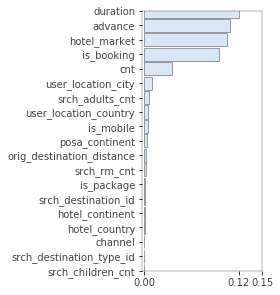

In [53]:
imp = importances(rf, df_imp, ytest)
viz = plot_importances(imp)
viz.view()

## Best Model: Min_sample_leaf=100, max_feature=16, max_depth=15, n_estimator=50

In [56]:
# Training the best model according to the plots with more depths (15) (100, 16)
rf = RandomForestClassifier(random_state=42,
                            n_jobs=4,
                            n_estimators=50,
                            min_samples_leaf=100,
                            max_features=16,
                            max_depth=15,
                            oob_score=True)
rf.fit(trans_xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features=16, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
                       oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [57]:
print(f"Training Accuracy Score: {accuracy_score(ytrain, rf.predict(trans_xtrain))}")
print(f"Testing Accuracy Score: {accuracy_score(ytest, rf.predict(trans_xtest))}")

Training Accuracy Score: 0.6154103177558652
Testing Accuracy Score: 0.6098678270273579


In [58]:
print(classification_report(ytest, rf.predict(trans_xtest)))

              precision    recall  f1-score   support

           0       0.66      0.90      0.77     19055
           1       0.99      1.00      0.99     22590
           2       0.52      0.54      0.53     21825
           3       0.65      0.36      0.46     11251
           4       0.55      0.63      0.59     17699
           5       0.50      0.47      0.49     31027
           6       0.50      0.36      0.42     19270
           7       0.53      0.51      0.52     12565
           8       0.65      0.74      0.69     16495
           9       0.52      0.53      0.52     24254

    accuracy                           0.61    196031
   macro avg       0.61      0.60      0.60    196031
weighted avg       0.61      0.61      0.60    196031



## Decision Tree with default parameters

In [36]:
dt = DecisionTreeClassifier()
dt.fit(trans_xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [37]:
# Accuracy scores
print(f"Training Accuracy Score: {accuracy_score(ytrain, dt.predict(trans_xtrain))}")
print(f"Testing Accuracy Score: {accuracy_score(ytest, dt.predict(trans_xtest))}")

Training Accuracy Score: 0.9953986869423713
Testing Accuracy Score: 0.5858002050696063


In [38]:
# Training Classification Report
print(classification_report(ytrain, dt.predict(trans_xtrain)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     75918
           1       1.00      1.00      1.00     90583
           2       0.99      1.00      0.99     86805
           3       0.99      1.00      1.00     45062
           4       1.00      1.00      1.00     70263
           5       0.99      0.99      0.99    124021
           6       1.00      0.99      1.00     76828
           7       1.00      0.99      1.00     50547
           8       1.00      0.99      0.99     66269
           9       1.00      0.99      0.99     97828

    accuracy                           1.00    784124
   macro avg       1.00      1.00      1.00    784124
weighted avg       1.00      1.00      1.00    784124



In [39]:
# Testing Classification Report
print(classification_report(ytest, dt.predict(trans_xtest)))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72     19055
           1       0.99      0.99      0.99     22590
           2       0.50      0.50      0.50     21825
           3       0.48      0.48      0.48     11251
           4       0.54      0.54      0.54     17699
           5       0.47      0.47      0.47     31027
           6       0.46      0.46      0.46     19270
           7       0.54      0.55      0.55     12565
           8       0.65      0.64      0.65     16495
           9       0.49      0.49      0.49     24254

    accuracy                           0.59    196031
   macro avg       0.59      0.58      0.58    196031
weighted avg       0.59      0.59      0.59    196031



## Hpyerparameter (max_depth) tuning manually for DecisionTree

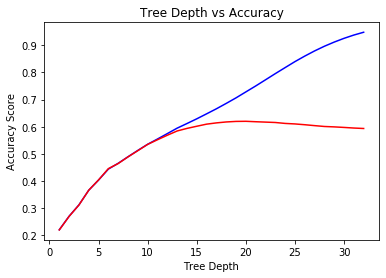

In [48]:
num_max_depths = np.arange(1,33)
accuracy_train = []
accuracy_test = []
for depth in num_max_depths:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(trans_xtrain, ytrain)
    
    acc_train = accuracy_score(ytrain, dt.predict(trans_xtrain))
    accuracy_train.append(acc_train)
    
    acc_test = accuracy_score(ytest, dt.predict(trans_xtest))
    accuracy_test.append(acc_test)
    
line1 = plt.plot(num_max_depths, accuracy_train, "b", label= "Train accuracy")
line2 = plt.plot(num_max_depths, accuracy_test, "r", label= "Test accuracy")

plt.title("Tree Depth vs Accuracy")
plt.ylabel("Accuracy Score")
plt.xlabel("Tree Depth")
plt.show()

In [53]:
# Training the decision tree model with max_depth and max_feature parameters
dt = DecisionTreeClassifier(max_depth=20)
dt.fit(trans_xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [54]:
# Accuracy scores
print(f"Training Accuracy Score: {accuracy_score(ytrain, dt.predict(trans_xtrain))}")
print(f"Testing Accuracy Score: {accuracy_score(ytest, dt.predict(trans_xtest))}")

Training Accuracy Score: 0.7278606444899021
Testing Accuracy Score: 0.6200651937703731


## KNN and LR with default parameters

In [61]:
def make_pipelines_knn_lr():
    pipe_log = Pipeline([('clf', LogisticRegression(multi_class='multinomial', solver='lbfgs' ))])
    pipe_knn = Pipeline([('scl', StandardScaler()),('clf', KNeighborsClassifier())])
    

    pipelines = [pipe_log, pipe_knn]
    
    return pipelines

In [62]:
pipelines = make_pipelines_knn_lr(); pipelines

[Pipeline(memory=None,
          steps=[('clf',
                  LogisticRegression(C=1.0, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='multinomial', n_jobs=None,
                                     penalty='l2', random_state=None,
                                     solver='lbfgs', tol=0.0001, verbose=0,
                                     warm_start=False))],
          verbose=False), Pipeline(memory=None,
          steps=[('scl',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('clf',
                  KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                       metric='minkowski', metric_params=None,
                                       n_jobs=None, n_neighbors=5, p=2,
                                       weights='uniform

### Precision score with testing data

In [63]:
#precision score
def sort_models_precision(pipelines, X_data, y_data, metric=accuracy_score, average="weighted"):
#     scores_sorted = {}

    score = []
    
    for pipe in pipelines:
        name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
        pipe.fit(X_data, y_data)
        y_train_pred = pipe.predict(X_data)
        accuracy = round(metric(y_data, y_train_pred, average=average), 2)
        score.append((name, accuracy))

    for model in score:
        print(f"test socre with {model[0]} is {model[1]}")
        
    return score

In [ ]:
sort_models_precision(pipelines, trans_xtest, ytest, metric=precision_score)

### Accuracy score with testing data

In [ ]:
#accuracy score
def sort_models_accuracy(pipelines, X_data, y_data, metric=accuracy_score):
#     scores_sorted = {}

    score = []
    
    for pipe in pipelines:
        name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
        pipe.fit(X_data, y_data)
        y_train_pred = pipe.predict(X_data)
        accuracy = round(metric(y_data, y_train_pred), 2)
        score.append((name, accuracy))

    for model in score:
        print(f"test socre with {model[0]} is {model[1]}")
        
    return score

In [ ]:
sort_models_accuracy(pipelines, trans_xtest, ytest, metric=accuracy_score)

## Using all the data (~4mil samples) for model training and testing

In [59]:
#reset the index
sample_x = df_X.reset_index(drop=True)
sample_y = df_y.reset_index(drop=True)
sample_x.info()

# feature engineering into datetime
sample_x['date_time'] = pd.to_datetime(sample_x['date_time'], yearfirst=True)
sample_x['srch_ci'] = pd.to_datetime(sample_x['srch_ci'], yearfirst=True, errors='coerce')
sample_x['srch_co'] = pd.to_datetime(sample_x['srch_co'], yearfirst=True, errors='coerce')

# timedelta for days in advance feature
sample_x['advance'] = sample_x['srch_ci'] - sample_x['date_time']
sample_x['advance'] = sample_x.advance.dt.days

# duration of stays
sample_x['duration'] = sample_x['srch_co'] - sample_x['srch_ci']
sample_x['duration'] = sample_x.duration.dt.days

new_x = sample_x.drop(columns=['user_id', 'site_name',
                               'user_location_region',
                               'date_time', 'srch_ci',
                               'srch_co'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3920622 entries, 0 to 3920621
Data columns (total 23 columns):
date_time                    object
site_name                    int64
posa_continent               int64
user_location_country        int64
user_location_region         int64
user_location_city           int64
orig_destination_distance    float64
user_id                      int64
is_mobile                    int64
is_package                   int64
channel                      int64
srch_ci                      object
srch_co                      object
srch_adults_cnt              int64
srch_children_cnt            int64
srch_rm_cnt                  int64
srch_destination_id          int64
srch_destination_type_id     int64
is_booking                   int64
cnt                          int64
hotel_continent              int64
hotel_country                int64
hotel_market                 int64
dtypes: float64(1), int64(19), object(3)
memory usage: 688.0+ MB


In [60]:
# Train test split the 5% data
xtrain, xtest, ytrain, ytest = train_test_split(new_x, sample_y, test_size=.2 ,random_state=42)
xtrain.shape, xtest.shape

((3136497, 19), (784125, 19))

In [61]:
# make the pipeline and transform the data
pipeline = make_pipeline()
trans_xtrain = pipeline.fit_transform(xtrain)
trans_xtest = pipeline.fit_transform(xtest)
trans_xtrain.shape # sanity check of datashape

(3136497, 19)

In [62]:
# Train the model
# Training the best model according to the plots with more depths (15) (100, 16)
rf = RandomForestClassifier(random_state=42,
                            n_jobs=4,
                            n_estimators=50,
                            min_samples_leaf=100,
                            max_features=16,
                            max_depth=15,
                            oob_score=True)

rf.fit(trans_xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features=16, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
                       oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [66]:
print(f"Training Accuracy Score: {round(accuracy_score(ytrain, rf.predict(trans_xtrain)), 2)}")
print(f"Testing Accuracy Score: {round(accuracy_score(ytest, rf.predict(trans_xtest)), 2)}")

Training Accuracy Score: 0.63
Testing Accuracy Score: 0.63


In [73]:
# oob score
print(f"Out of Bag Accuracy: {rf.oob_score_}")

Out of Bag Accuracy: 0.6259231237906493


In [67]:
# F1-scores
print(f"Training weighted-f1-Score: {round(f1_score(ytrain, best_rf.predict(trans_xtrain), average='weighted'), 2)}")
print(f"Testing weighted-f1-Score: {round(f1_score(ytest, best_rf.predict(trans_xtest), average='weighted'), 2)}")

Training weighted-f1-Score: 0.56
Testing weighted-f1-Score: 0.56


In [65]:
# Testing Classification Report
print(classification_report(ytest, rf.predict(trans_xtest)))

              precision    recall  f1-score   support

           0       0.67      0.91      0.77     76421
           1       0.99      0.99      0.99     90489
           2       0.54      0.54      0.54     86933
           3       0.70      0.39      0.50     45043
           4       0.57      0.64      0.60     70054
           5       0.52      0.50      0.51    123879
           6       0.54      0.38      0.45     76681
           7       0.57      0.53      0.55     50372
           8       0.66      0.76      0.71     66592
           9       0.53      0.55      0.54     97661

    accuracy                           0.63    784125
   macro avg       0.63      0.62      0.62    784125
weighted avg       0.63      0.63      0.62    784125



In [71]:
print(f"Training Precision Score: {precision_score(ytrain, rf.predict(trans_xtrain), average='weighted')}")
print(f"Testing Precision Score: {precision_score(ytest, rf.predict(trans_xtest), average='weighted')}")

Training Precision Score: 0.6281337001937058
Testing Precision Score: 0.6250377735366721
